In [1]:
library(Seurat) #v2.3.4 main
library(magrittr)
library(velocyto.R)
library(ggplot2)
source("../../R/Seurat_functions.R")

Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# 6.1 load seurat

In [2]:
(load(file = "../data/Glioma_Harmony_20181201.Rda"))
Glioma@meta.data$group = gsub("\\-.*","",Glioma@meta.data$orig.ident)
table(Glioma@meta.data$group)

[1] "Glioma"


PM1005 PM1258 PM1415 PM1559 PM1568 
  8929   7791  17402  11775  13038 

In [3]:
Glioma <- SetAllIdent(Glioma,id="group")
sub_object <- SubsetData(Glioma, ident.use = "PM1005")

In [4]:
tsne <- sub_object@dr$tsne@cell.embeddings[,1:2]
row.names(tsne) <- stringi::stri_replace_last_fixed(row.names(tsne),"_",":")
row.names(tsne) <- paste0(row.names(tsne),"x")
remove(Glioma)
GC() # Clean memory

# 6.3 Extract color code and TSNE embeddings

      colour
1    #F8766D
2393 #7CAE00
3326 #00BFC4
5875 #C77CFF


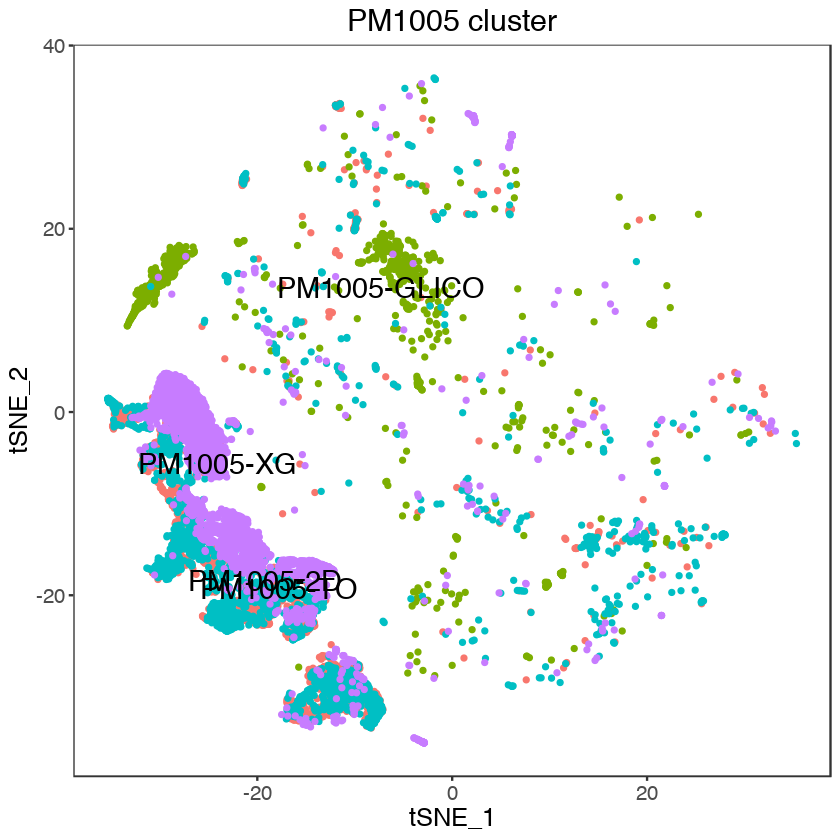

In [14]:
gg_colors <- function(object = object, no.legend = TRUE, do.label = TRUE,
                      do.return = TRUE, label.size = 6, gg_title=""){
        g1 <- Seurat::TSNEPlot(object = object, no.legend = no.legend,
                               do.label = do.label,do.return = do.return,
                               label.size = label.size)+
                ggtitle(gg_title)+
                theme(text = element_text(size=15),     #larger text including legend title							
                      plot.title = element_text(hjust = 0.5)) #title in middle
        print(g1)
        g <- ggplot2::ggplot_build(g1)
        print(unique(g$data[[1]]["colour"]))
        colors <- unlist(g$data[[1]]["colour"])
        cells <- Seurat::WhichCells(object)
        cells <- gsub("-1$","",cells)
        names(colors) <- stringi::stri_replace_last_fixed(cells,"_",":")
        names(colors) <- paste0(names(colors),"x")
        
        return(colors)
}
sub_object <- SetAllIdent(sub_object,id="orig.ident")
cell.colors <- gg_colors(object = sub_object, gg_title="PM1005 cluster")

In [7]:
cell.colors <- as.character(sub_object@meta.data$singler2sub.colors)
cells <- rownames(sub_object@meta.data)
cells <- gsub("-1$","",cells)
names(cell.colors) <- stringi::stri_replace_last_fixed(cells,"_",":")
names(cell.colors) <- paste0(names(cell.colors),"x")

# 6.4 load loom file

In [8]:
ldat <- read.loom.matrices("../data/velocyto/PM1005_merged.loom")

reading loom file via hdf5r...


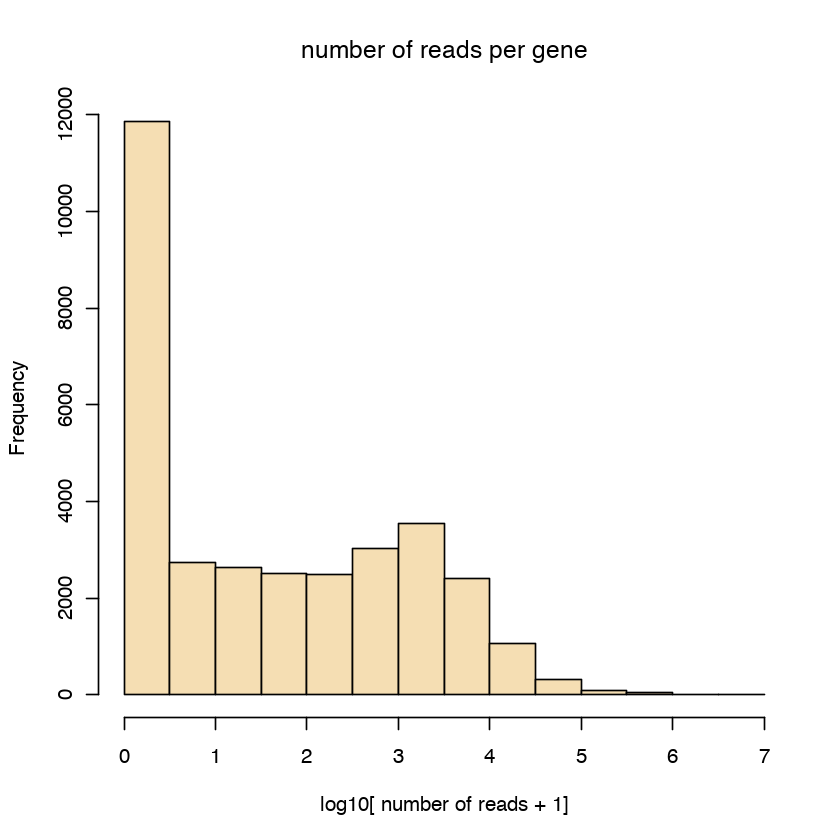

In [9]:
hist(log10(rowSums(ldat$spliced)+1),col='wheat',xlab='log10[ number of reads + 1]',
     main='number of reads per gene')

In [22]:
emat <- ldat$spliced # exonic read (spliced) expression matrix
nmat <- ldat$unspliced # intronic read (unspliced) expression matrix
smat <- ldat$ambiguous # spanning read (intron+exon) expression matrix
str(emat@Dim);str(nmat@Dim);str(smat@Dim)
# look at the resulting gene set
str(intersect(intersect(rownames(emat),rownames(nmat)),rownames(smat)))

 int [1:2] 32738 9411
 int [1:2] 32738 9411
 int [1:2] 32738 9411
 chr [1:32643] "FAM138A" "RP11-34P13.7" "RP11-34P13.8" "AL627309.1" ...


In [23]:
# filter expression matrices based on some minimum max-cluster averages
emat <- filter.genes.by.cluster.expression(emat,cell.colors,min.max.cluster.average = 0.1)
nmat <- filter.genes.by.cluster.expression(nmat,cell.colors,min.max.cluster.average = 0.05)
smat <- filter.genes.by.cluster.expression(smat,cell.colors,min.max.cluster.average = 0.01)
str(emat@Dim);str(nmat@Dim);str(smat@Dim)
# look at the resulting gene set
length(intersect(rownames(emat),rownames(nmat)))
str(intersect(intersect(rownames(emat),rownames(nmat)),rownames(smat)))

 int [1:2] 9304 9411
 int [1:2] 9745 9411
 int [1:2] 5964 9411


[1] 6320

 chr [1:3452] "CPSF3L" "CCNL2" "MRPL20" "GNB1" "C1orf86" "CEP104" "RPL22" ...


# 6.5 calculate gene-relative velocity

Alternatively, wen can use spanning reads (smat) to fit the gene offsets. This will result in more accurate offset estimates, but for much fewer genes (spanning reads are rare). Note that here we also use optional diagona.quantiles setting to estimate extreme quantiles on a normalized sum of splcied and unspliced signal:

In [24]:
rvel <- gene.relative.velocity.estimates(emat,nmat,deltaT=1, kCells = 5, fit.quantile=0.05)

calculating cell knn ... done
calculating convolved matrices ... done
fitting gamma coefficients ... done. succesfful fit for 6320 genes
filtered out 1054 out of 6320 genes due to low nmat-emat correlation
filtered out 369 out of 5266 genes due to low nmat-emat slope
calculating RNA velocity shift ... done
calculating extrapolated cell state ... done


# 6.7 Visualization on an existing embedding

delta projections ... sqrt knn ... transition probs ... done
calculating arrows ... done


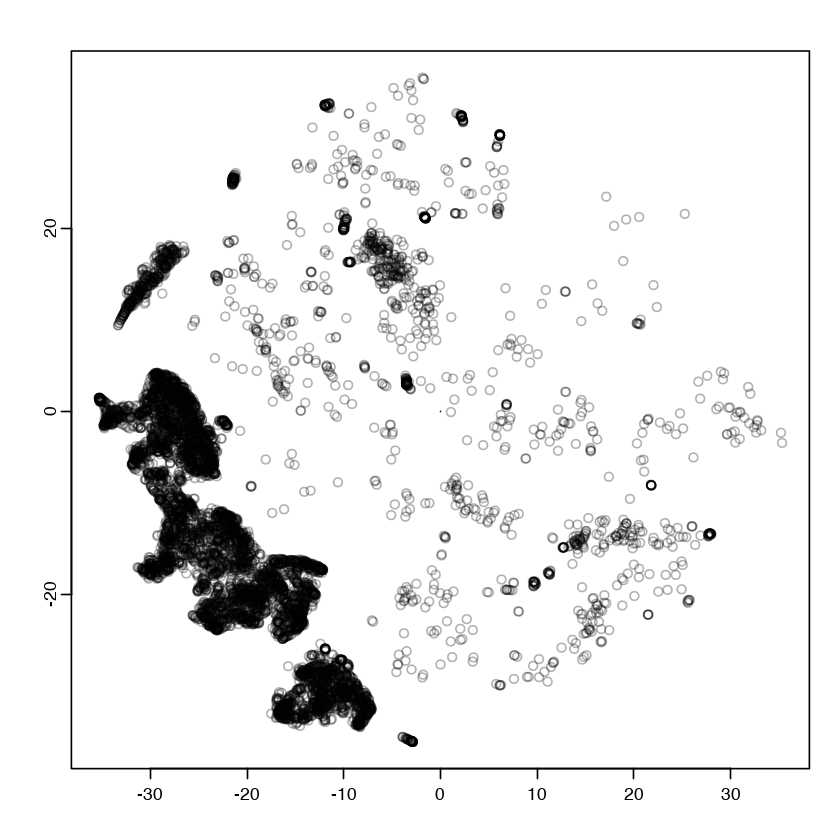

In [26]:
arrow.scale=6; cell.alpha=1; cell.cex=1; fig.height=4; fig.width=4.5;
show.velocity.on.embedding.cor(tsne,rvel,n=100,scale='sqrt',cell.colors=ac(cell.colors,alpha=0.4),
                               cex=cell.cex,arrow.scale=arrow.scale,arrow.lwd=1)

Alternatively, the same function can be used to calculate a velocity vector field:

delta projections ... sqrt knn ... transition probs ... done
calculating arrows ... done
grid estimates ... 

Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”

ERROR: Error in seq.default(rx[1], rx[2], length.out = grid.n): 'from' must be a finite number


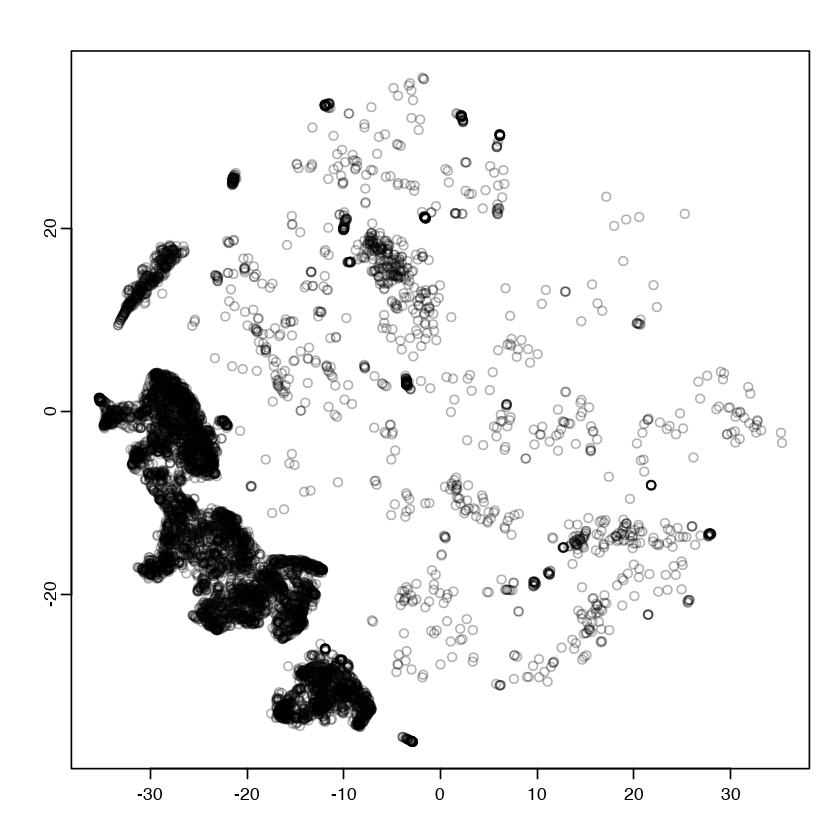

In [27]:
show.velocity.on.embedding.cor(tsne,rvel,n=100,scale='sqrt',cell.colors=ac(cell.colors,alpha=cell.alpha),
                               cex=cell.cex,arrow.scale=arrow.scale,
                               show.grid.flow=TRUE,min.grid.cell.mass=0.5,
                               grid.n=20,arrow.lwd=2)

# Velocity estimate based on gene structure
To estimate velocity based on gene structure parameters, we need to parse the gtf file as well as the debug hdf5 output of velocyto.py (-d option) which contains per-exon mapping information. You can fetch the exact gtf file used here. First, however, we will compile information on the internal priming sites expected in this genome (mouse UCSC mm10 assembly):

sqrt scale ... reducing to 30 PCs ... 

Warning message in pcaMethods::pca(t(em - epc.center), center = F, nPcs = nPcs):
“more components than matrix rows requested”

ERROR: Error in pcaMethods::pca(t(em - epc.center), center = F, nPcs = nPcs): Invalid data format.Run checkData(data, verbose=TRUE) for details


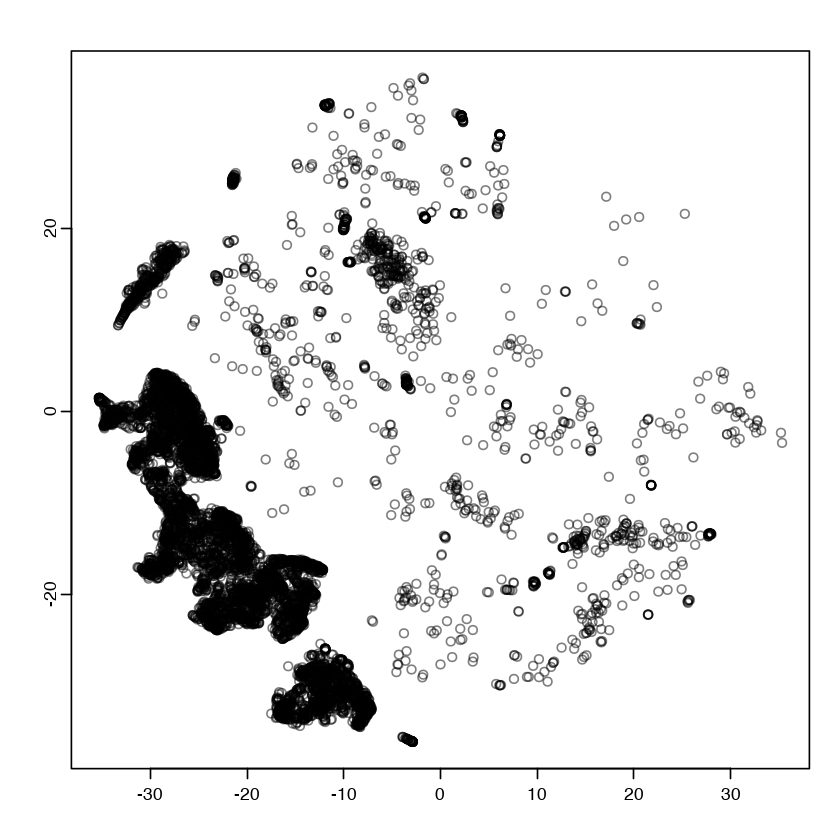

In [28]:
x <- show.velocity.on.embedding.eu(tsne,rvel,n=40,scale='sqrt',cell.colors=ac(cell.colors,alpha=cell.alpha),
                                   cex=cell.cex,nPcs=30,sigma=2.5,show.trajectories=TRUE,diffusion.steps=400,
                                   n.trajectory.clusters=15,ntop.trajectories=1,embedding.knn=T,
                                   control.for.neighborhood.density=TRUE,n.cores=40) 

In [99]:
head(sub_object@meta.data)

,nGene,nUMI,Sample,Barcode,is_cell_control,total_features_by_counts,log10_total_features_by_counts,total_counts,log10_total_counts,pct_counts_in_top_50_features,⋯,CC.Difference,res.0.6,singler1sub,singler1main,singler2sub,singler2main,kang,singler1sub.colors,singler2sub.colors,group
PM1005-2D_AAACCTGAGCGCTTAT-1,4062,19124,./data/PM1005-2D/outs/filtered_gene_bc_matrices/hg19,AAACCTGAGCGCTTAT-1,FALSE,4062,3.608847,19124,4.281601,32.84355,⋯,0.024470035,6,Mesenchymal,Mesenchymal,Fibroblasts,Fibroblasts,Megakaryocytes,#FFD92F,#66A61E,PM1005
PM1005-2D_AAACCTGCATTAGGCT-1,2854,11238,./data/PM1005-2D/outs/filtered_gene_bc_matrices/hg19,AAACCTGCATTAGGCT-1,FALSE,2854,3.455606,11238,4.050728,36.44777,⋯,-0.076132764,14,Mesenchymal,Mesenchymal,Fibroblasts,Fibroblasts,Megakaryocytes,#FFD92F,#66A61E,PM1005
PM1005-2D_AAACCTGTCATAAAGG-1,4565,30096,./data/PM1005-2D/outs/filtered_gene_bc_matrices/hg19,AAACCTGTCATAAAGG-1,FALSE,4565,3.659536,30096,4.478523,39.23777,⋯,-0.001966829,14,Mesenchymal,Mesenchymal,Fibroblasts,Fibroblasts,Megakaryocytes,#FFD92F,#66A61E,PM1005
PM1005-2D_AAACCTGTCCCTTGTG-1,4068,17163,./data/PM1005-2D/outs/filtered_gene_bc_matrices/hg19,AAACCTGTCCCTTGTG-1,FALSE,4068,3.609488,17163,4.234619,29.86075,⋯,0.097885565,6,Mesenchymal,Mesenchymal,Fibroblasts,Fibroblasts,Megakaryocytes,#FFD92F,#66A61E,PM1005
PM1005-2D_AAACCTGTCTTCATGT-1,3460,14961,./data/PM1005-2D/outs/filtered_gene_bc_matrices/hg19,AAACCTGTCTTCATGT-1,FALSE,3460,3.539202,14961,4.174990,39.35566,⋯,0.021669158,12,Mesenchymal,Mesenchymal,Fibroblasts,Fibroblasts,Megakaryocytes,#FFD92F,#66A61E,PM1005
PM1005-2D_AAACGGGAGTGCCAGA-1,4840,22339,./data/PM1005-2D/outs/filtered_gene_bc_matrices/hg19,AAACGGGAGTGCCAGA-1,FALSE,4840,3.684935,22339,4.349083,27.09611,⋯,0.060137307,6,Mesenchymal,Mesenchymal,Fibroblasts,Fibroblasts,Megakaryocytes,#FFD92F,#66A61E,PM1005


In [15]:
table(cell.colors)

cell.colors
#00BFC4 #7CAE00 #C77CFF #F8766D 
   2549     933    3055    2392 